In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Distributions
import MassRatioDistribution
import Simulation
import h5py
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

# Binary Inference with my data

The purpose of this notebook is to go over the method I propose to use to measure the power-law slope in the mass-ratio distribution from my data. The data I have for each star is:

  1. Estimate of the primary star temperature. Most of this comes from [David & Hillenbrand (2015)](http://adsabs.harvard.edu/abs/2015ApJ...804..146D), which used Stromgren photometry to measure $T_{\rm eff}$ and $\log{g}$, and used Padova isochrones to give the primary stars a mass and age distribution. Some of my targets are not in my sample, for which I need to fall back on the literature spectral type of the star.
  2. Estimate of the companion star temperature. This comes from the analysis in my previous paper, and usually comes with uncertainties of $\sim 100-200$ K.
  3. Radial velocity of the primary star and companion star at 1-4 epochs (hopefully). I am working on measuring this now. The difficulty with the primary star RVs is that a lot of the power is in the strong Balmer lines, which span 2-3 echelle orders. I have had some success flattening the spectra with the help of model spectra. I plan to pin the velocities to the telluric lines for all instruments, so hopefully they are at least consistent velocities if not absolute ones. The companion velocities are easier; they come straight out of the cross-correlation functions.
  
What I want to know is this: is the distribution of mass-ratios significantly different for the close companions that I am sensitive to than the wide companions that imaging surveys have found? I will be fitting the mass-ratio distribution to a power law with index $\gamma$:

$$ P(\gamma) = (1-\gamma) q^{-\gamma} $$

The difficulty is that my survey has a bunch of completeness effects and biases:

## Completeness Effects

  My survey uses high signal-to-noise ratio spectra to directly search for the companion spectral lines. This works quite well even when the lines are marginally buried within the noise, but is not magic. The overall sensitivity for a given star depends on the mass-ratio (actually the flux ratio, but they are 1:1), and the companion $v\sin{i}$, and look like this:
  
<img src="Figures/Typical_Sensitivity.png" >

As I do in my previous paper, I can marginalize the $v\sin{i}$ dependence away by assuming a suitable distribution of companion $v\sin{i}$ values and get sensitivity curves that only depend on the mass-ratio and look like sigmoids. I will therefore plan to model each star with its own sensitivity curve, and parameterize the sensitivity as:

$$Q(q) = \frac{1}{1+e^{-\alpha(q-\beta)}}  $$

$\alpha$ and $\beta$ are parameters that will depend on the system I am talking about. Here is some intuition for what they look like:

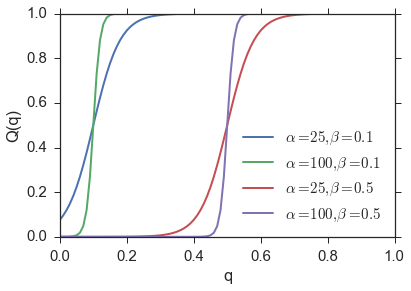

In [3]:
def sigmoid(x, alpha, beta):
    return 1.0 / (1.0 + np.exp(-alpha*(x-beta)))

x = np.arange(0, 1, 0.01)
for beta in [0.1, 0.5]:
    for alpha in [25, 100]:
        y = sigmoid(x, alpha, beta)
        plt.plot(x, y, label=r'$\alpha = {}, \beta = {}$'.format(alpha, beta), lw=2)
plt.xlabel('q')
plt.ylabel('Q(q)')
leg = plt.legend(loc=4, fancybox=True)
plt.savefig('Figures/Completeness.png')

I also lose sensitivity at very high mass-ratios, because the companions can be rapid rotators with relatively few lines and my primary star removal stuff just kills the companion as well. I will have to think about how to include that effect.

## Malmquist Bias

My survey is magnitude-limited, and is therefore malmquist-biased. The effect of Malmquist bias is to make large mass-ratios appear more likely since they both contribute flux. The mass-ratio ends up being biased as a result:

<img src="Figures/Malmquist.png">

I will estimate this with a quick Monte Carlo simulation. the probability of being in my sample is essentially:

\\[
P(obs) =
  \begin{cases}
    1 & \text{if } V < 6 \\
    0 & \text{otherwise}
  \end{cases}
\\]

Now V, the apparent V-band magnitude of the target, is of course a function of the distance ($\rho$) to the star and the absolute magnitude of the star:

$$ V = M_V + 5\log{\rho} - 5 $$

In the case of binary stars, the absolute magnitude is coming from the light of two stars with primary mass $M_1$ and companion mass $qM_1$:

$$ M_{v, total}(q, M_1) = -2.5\log{10^{-M_v(M_1)/2.5} + 10^{-M_v(qM_1)/2.5}} $$

The function $M_v(M)$ is the absolute magnitude of a main-sequence star with mass M, and can be interpolated from stellar evolution models or observational tables such as [this one](http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt). What we want is the probability that a given binary system has $V<6$, as a function of mass-ratio ($q$). 

I draw random primary star masses from the Salpeter IMF from $1.5 - 20 M_{\odot}$:

$$P(M)dM \sim M^{-2.35}dM $$

and distances assuming they uniformly fill a sphere of size 1 kpc. For each sample, I can calculate the apparent visual magnitude as a function of binary mass-ratio, and come up with a probability of some star being in my sample, given its mass-ratio ($P(obs | q)$).

<img src='Figures/Malmquist_Pobs.png' >

As you can see, the probability of being in my sample increases with mass-ratio. TODO: work out a better way to parameterize this than with simple polynomials! It should never have negative slope.

# Inference Technique

I will be going off of Dan Foreman-Mackey's work on exoplanet inference to do my binary star population inference. The idea is:

  - Fit orbits to each binary system. These will be grossly un-constrained, but that is fine. I used Nested Sampling (similar to MCMC) to get samples from the posterior distribution for
  
  $$p(\omega_k|x_k, \alpha) = \frac{p(x_k|\omega_k)p(\omega_k|\alpha)}{p(x_k|\alpha)} $$
  
    - $x_k$ is the set of radial velocities for star k
    - $\omega_k$ is the set of orbital parameters for star k. $\omega_k = (a, M_0, e, \omega, K_1, q, \Delta v)$
    - $\alpha$ is just notation for the priors you set on the orbital elements.
  
  - Use the orbit parameter posterior samples to estimate the MRD power law slope, accounting for uncertainties.

Here is the key equation:

$$p(\{x_k\} | \theta) = p(\{x_k\} | \alpha) \exp\left(- \int Q_c(\omega) \Gamma_{\theta}(\omega) d\omega \right) \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} \frac{Q_c(\omega_k^{(n)}) \Gamma_{\theta}(\omega_k^{(n)})}{p(\omega_k^{(n)} | \alpha)} $$

The various terms are:

  - $p({x_k}|\theta)$: This is the probability of observing the dataset (${x_k}$), given the parameters $\theta = (\gamma, \mu, \sigma, \eta)$
    - $\gamma$ is the MRD power law slope
    - $\eta$ is the same thing for the eccentricity distribution
    - $\mu, \sigma$ are the mean and standard deviation of the log-normal semi-major axis distribution.
    - This is the **likelihood function for the data**
  - $Q_c(\omega)$: The completeness of the survey for orbital parameters $\omega$. This is the mean of the completeness sigmoid curves for all sample stars times the malmquist bias adjustment factor.
  - $\Gamma_{\theta}(\omega) = \Gamma(a, e, q | \gamma, \mu, \sigma, \eta) = \Gamma(q|\gamma) \Gamma(a|\mu, \sigma) \Gamma(e|\eta) $: This is the *rate density* of binary companions with semimajor axis a, eccentricity e, and mass-ratio q, given the distribution parameters $\theta$. In my model, $\Gamma$ is separable with each component as:
    - $\Gamma(q|\gamma) = (1-\gamma)q^{-\gamma} $
    - $\Gamma(a|\mu, \sigma) = \frac{1}{a\sqrt{2\pi\sigma^2}} e^{-0.5(\ln{a} - \mu)^2 / \sigma^2} $
    - $\Gamma(e|\eta) = (1-\eta)e^{-\eta} $

The integral is over all possible parameter space $\omega$, which seems daunting, but for my case at least it is separable. The eccentricity and semimajor axis integrals are just 1, but the mass-ratio integral is now:
$$
\begin{align}
\int_0^1 Q_{\rm tot}(q)\Gamma(q)dq &= \int_0^1 \frac{1}{N} \sum_{i=1}^N Q_i(q)\Gamma(q)dq \\
 &= \frac{1}{N} \sum_{i=1}^N \int_0^1 \frac{(1-\gamma)q^{-\gamma}}{1+e^{-\alpha_i(q-\beta_i)}}
\end{align}
$$

I will implement the inner integral in C for speed, and then calculate the integral for every value of $\alpha/\beta$ in the sample and sum the results. Here is the relevant C code, listed in 'integration.c' within this repository:

```C
double q_integrand_logisticQ(int n, double args[n])
{
    //unpack arguments
    double q = args[0];
    double gamma = args[1];
    double alpha = args[2];
    double beta = args[3];

    return (1-gamma)*pow(q, -gamma) / (1.0 + exp(-alpha*(q-beta)));
}
```

I compile it into a shared library with

```bash
gcc -shared -o integrandlib.so -fPIC integration.c
```

# Simulation Results

So that is the basic idea. Now I will run a series of simulations to check if it gets the right answer. Each test will increase the complexity some.

## 1: Well-constrained orbits with no biases or censoring.
This is just a sanity check to make sure the main equation above will give us the right answer. I will simulate 400 stars that all have a binary companions, using the following parameters:

  - $\gamma = 0.4$
  - $\mu = \log{200} \approx 5.3$
  - $\sigma = \log{10} \approx 2.3$
  - $\eta = 0.7$
  
I first generate the true orbital parameters for each system, and then sample the orbits by choosing 20 random epochs for an rv observation and 3 random epochs for an imaging observation. I allow for random errors on the measurements with amplitude

  - $\sigma_{v_1} = 0.1$ km/s
  - $\sigma_{v_2} = 0.2$ km/s
  - $\sigma_p = 10$ mas  (position uncertainty)
  

In [9]:
import h5py
import Distributions
with h5py.File('Simulation_Data_backup20150904.h5', 'r') as f:
    samples = np.array([f['plain/ds{}'.format(i)].value for i in range(400)])

# Set up the prior and completeness functions. I need to hack them somewhat for this simple case...
#prior = Distributions.OrbitPrior(2, 5700, gamma=0.0, cache=True)
#prior._cache = 1.0
prior = lambda lnq, lna, lne: 0.0
completeness = Distributions.CensoredCompleteness(alpha_vals=np.ones(samples.shape[0])*np.inf, 
                                                  beta_vals=np.ones(samples.shape[0])*-10)

# Make a fitter instance and get the maximum likelihood values for the parameters
fitter = Distributions.DistributionFitter(samples, prior_fcn=prior, completeness_fcn=completeness,
                                          integral_fcn=completeness.integral)
fitter.guess_fit_parameters()

array([ 0.37929049,  5.4077147 ,  2.26678427,  0.68829558])

It gets pretty close to the right answer. Let's go ahead and fit it with MCMC to make sure that it gets the everything right within the limits

In [ ]:
par_ranges = [[0, 0.999], [1e-3, 10], [1e-3, 10], [0, 0.999] ]
fitter.fit(backend='emcee', nwalkers=100, n_burn=1, n_prod=400, guess=False, 
           initial_pars=par_ranges)
fitter.make_emcee_samples(200)
fitter.triangle(truths=[0.4, np.log(200), np.log(10), 0.7])

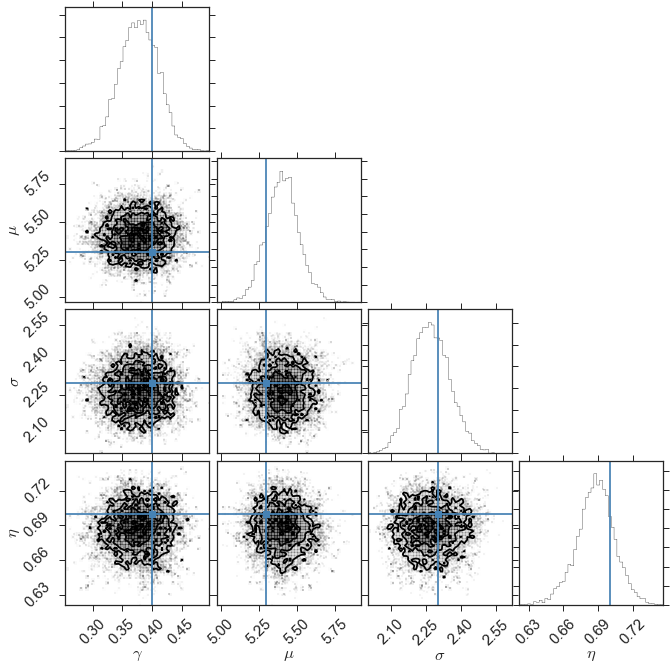

In [16]:
fitter.triangle(truths=[0.4, np.log(200), np.log(10), 0.7])
plt.savefig('Figures/Triangle_well_constrained.png')

Perfect! Moving on.

## 2: Very un-constrained orbits

Next up is seeing how well this method does when the orbits are much less constrained. I expect the overall uncertainty to be larger, but hopefully we still get overall the right answer. I will sample orbits just like above, except I will only have 2 rv epochs and *no* imaging observations. This is what I have for most of my stuff.

Whereas before the orbit fits were pretty straightforward, I now need to put a lot more thought into what is going on, what priors I want to use, and how to get a decent fit. For poorly constrained orbits, the emcee code fails to adequately explore the parameter space and has trouble if there are multiple peaks in the posterior distributions. [MultiNest](https://github.com/JohannesBuchner/PyMultiNest) works much better and is almost as easy to use, so I use that. 

### Priors:

The priors for everything except the mass-ratio are:

  - a: log-uniform from $10^{-2} - 10^6$ AU
  - M_0, \omega: Both uniform from $0 - 360^{\circ}$
  - e: log-uniform from $10^{-20} - 0$
  - $K_1$ (RV semi-amplitude of the primary star): log-uniform from $10^{-3} - 10^3$ km/s
  - $\Delta v$ (the system velocity): Uniform from $-20 - 20$ km/s. This is 0 for all simulated stars.
  
The mass-ratio prior is more complicated. If I just use a uniform prior, many of the binaries have an unconstrained mass-ratio because that is somewhat degenerate with the system velocity ($\Delta v$). But I have more information: the companion temperatures! I use the companion temperature to estimate companion masses, and assume the primary mass is correct within $1 M_{\odot}$, to estimate the mass-ratio prior. For these simulations I go about it pretty circularly, but I am pretty sure it is a justified procedure for my main sample. Here is some code with what I do:

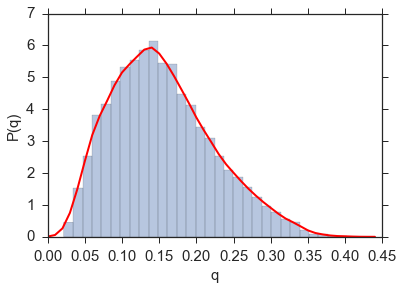

In [2]:
import Mamajek_Table
import scipy
from scipy.stats import truncnorm
MT = Mamajek_Table.MamajekTable()
teff2mass = MT.get_interpolator('Teff', 'Msun')
mass2teff = MT.get_interpolator('Msun', 'Teff')

M1_mean = 2.1
q_true = 0.2
M1_std = 1.0

# Sample the primary mass's uncertainty
a, b = (1.5-M1_mean)/M1_std, np.inf
M1_vals = truncnorm.rvs(a=a, b=b, loc=M1_mean, scale=M1_std, size=10000)

# Sample the companion temperature uncertainty, and convert to mass
T2_mean = mass2teff(M1_mean*q_true)
T2_vals = np.random.normal(loc=T2_mean, scale=200, size=10000)
M2_vals = teff2mass(T2_vals)

# Compute mass-ratio samples
q_vals = M2_vals/M1_vals

# Use kernel density estimation to get the PDF
kde = scipy.stats.gaussian_kde(q_vals)

# Plot
_ = plt.hist(q_vals, bins=30, normed=True, alpha=0.4)
qplot = np.arange(*plt.xlim(), step=0.01)
_ = plt.plot(qplot, kde(qplot), 'r-', lw=2)
_ = plt.xlabel('q', fontsize=15)
_ = plt.ylabel('P(q)', fontsize=15)
plt.savefig('Figures/qprior.png')

So my mass-ratio prior, like my completeness, is different for each sample star. However, it turns orbit fit posteriors that look like this 

<img src="Figures/no_qprior.png">

into this

<img src="Figures/with_qprior.png">

Most of the parameters are un-changed, but now the mass-ratio is dominated by the (somewhat) informative prior. When there is actually enough dynamical information to constrain the mass-ratio, the prior becomes unimportant.

### Distribution Fitting

Once I have "orbit fits" for all of the simulated sample stars, I need to fit the overall distributions. The code for this looks much the same as above, since there is still no bias or censoring happening in the data.

high_q = 1.0
factor = 0.0
Generating posterior plot...


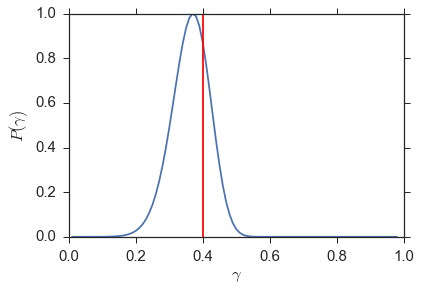

In [17]:
data, M_prim, M_sec, a, e = Simulation.read_orbit_samples('Simulation_Data_jayhawk_total.h5', 
                                                          'representative_pool_highq',
                                                           censor=False)

# Make all mass-ratios in [0,1]
q = data[:, :, 0]
q[q>1.0] = 1.0/q[q>1.0] 

# Hard-censor low mass-ratios because the orbit prior causes things to get bad
lowq = (M_sec / M_prim) < 0.1
q[lowq] = np.nan

T_sec = Distributions.mass2teff(M_sec)
prior = MassRatioDistribution.OrbitPrior(M_prim, T_sec, gamma=0.0, cache=True)
prior._cache = 1.0

#completeness = lambda lnq: 500.0 
#integral = lambda fbin, gamma, malm: 500.0*fbin
completeness = lambda q: 500 * np.array(q > 0.1, dtype=bool)
integral = lambda fbin, gamma, malm: 500.0*fbin*(1-0.1**(1-gamma))

fitter = MassRatioDistribution.GammaFitter(q,
                                           prior_fcn=prior,
                                           completeness_fcn=completeness,
                                           integral_fcn=integral)

print('Generating posterior plot...')
gamma_vals = np.arange(0.01, 0.99, 0.01)
ll = np.empty_like(gamma_vals)
for i, gamma in enumerate(gamma_vals):
    ll[i] = fitter.lnlike(gamma)
    if np.isinf(ll[i]):
        break

plt.plot(gamma_vals, np.exp(ll-ll.max()))
plt.xlabel('$\gamma$')
plt.ylabel('$P(\gamma)$')
plt.plot((0.4, 0.4), plt.ylim(), 'r-')
plt.savefig('Figures/Gamma_Representative_HardCensor.pdf')

Now, the semimajor axis and eccentricity distributions are completely dominated by the orbit priors, and we can't do anything with them. So, I will leave them out from now on and just show posteriors for the stuff we care about. You can see that we overestimate the mass-ratio distribution parameter, basically claiming that low mass ratios are more likely than they should be. However, that is really just an issue because the mass ratio prior fails when the true temperature gets close to $3000\ \rm K$, because that is about where the table I am interpolating stops being complete. That shouldn't actually be an issue for me, since none of my companions are quite that cool (because that is below my detection limit). The problem nicely goes away when I introduce censored data...


## 3. Censoring

Now, I will introduce detection rate curves that are different for each sample star. Most of the detection rates will cut off around q=0.2, but with some spread in where the cutoff is and how sharp it is.

high_q = 1.0
factor = 0.0
Generating posterior plot...


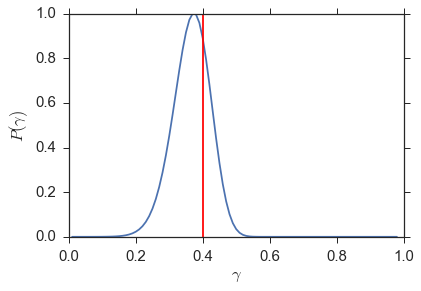

In [32]:
reload(Distributions)
tmp = {}
tmp['alpha'] = np.random.normal(loc=30, scale=5, size=500)
tmp['beta'] = np.random.normal(loc=0.2, scale=0.03, size=500)
censored_sample_parameters = pd.DataFrame(data=tmp)

censored_data, censored_M_prim, censored_M_sec, censored_a, censored_e = Simulation.read_orbit_samples('Simulation_Data_jayhawk_total.h5', 
                                                                                   'representative_pool_highq',
                                                                                   censor=True, 
                                                                                   sample_parameters=censored_sample_parameters)

# Make all mass-ratios in [0,1]
q = censored_data[:, :, 0]
q[q>1.0] = 1.0/q[q>1.0] 


censored_T_sec = Distributions.mass2teff(censored_M_sec)
censored_prior = MassRatioDistribution.OrbitPrior(censored_M_prim, censored_T_sec, gamma=0.0, cache=True)
censored_prior._cache = 1.0
censored_completeness = MassRatioDistribution.CensoredCompleteness(alpha_vals=censored_sample_parameters['alpha'],
                                                                   beta_vals=censored_sample_parameters['beta'])

censored_fitter = MassRatioDistribution.GammaFitter(q, 
                                                    prior_fcn=censored_prior, 
                                                    completeness_fcn=censored_completeness,
                                                    integral_fcn=censored_completeness.integral)

print('Generating posterior plot...')
gamma_vals = np.arange(0.01, 0.99, 0.01)
ll = np.empty_like(gamma_vals)
for i, gamma in enumerate(gamma_vals):
    ll[i] = censored_fitter.lnlike(gamma)
    if np.isinf(ll[i]):
        break

plt.plot(gamma_vals, np.exp(ll-ll.max()))
plt.xlabel('$\gamma$')
plt.ylabel('$P(\gamma)$')
plt.plot((0.4, 0.4), plt.ylim(), 'r-')

So to recap, I am nailing the mass-ratio distribution by starting with a bunch of stars with 2 velocity points. That is actually pretty impressive! So far, I have been sampling the parent distribution in a representative way; in my real sample there is malmquist bias...

## 4. Malmquist biased and censored sample

We will keep the censoring, but now will have a malmquist-biased sample. They way that impacts the mass-ratio distribution is described near the top of this document, but in short it alters the probability of observing a given mass-ratio. The simulations I did earlier gave me a polynomial fit to $P(obs|q)$, the probabibility of observing a star given its mass ratio. We can use Bayes' equation to get what we want:

$$P(q|obs, \gamma) = \frac{P(obs|q)P(q| \gamma)}{\int_0^1 P(obs|q)P(q| \gamma)dq} $$

I am parameterizing $P(obs|q)$ and $P(q| \gamma)$ as:

$$
\begin{align}
P(obs|q) &= a + bq + cq^2 + dq^3 + eq^4 + fq^5 \\
P(q| \gamma) &= (1-\gamma)q^{-\gamma}
\end{align}
$$

In this case the integral has an analytic solution:

$$ \int_0^1 P(obs|q)P(q| \gamma)dq = a + \frac{1-\gamma}{2-\gamma}b + \frac{1-\gamma}{3-\gamma}c + \frac{1-\gamma}{4-\gamma}d + \frac{1-\gamma}{5-\gamma}e + \frac{1-\gamma}{6-\gamma}f $$

So now in the likelihood evaluation, I use $P(q|obs, \gamma)$ instead of $\Gamma_q(\gamma)$ but everything else stays the same.

In [ ]:
tmp = {}
tmp['alpha'] = np.random.normal(loc=30, scale=5, size=400)
tmp['beta'] = np.random.normal(loc=0.2, scale=0.03, size=400)
malm_sample_parameters = pd.DataFrame(data=tmp)

malm_data, malm_M_prim, malm_M_sec, malm_a, malm_e = Simulation.read_orbit_samples('Simulation_Data.h5', 
                                                                                   'unconstrained_mn_malmquist',
                                                                                   censor=True, 
                                                                                   sample_parameters=malm_sample_parameters)


malm_T_sec = Distributions.mass2teff(malm_M_sec)
malm_prior = Distributions.OrbitPrior(malm_M_prim, malm_T_sec, gamma=0.0, cache=True)
malm_completeness = Distributions.CensoredCompleteness(alpha_vals=malm_sample_parameters['alpha'],
                                                       beta_vals=malm_sample_parameters['beta'])
malm_coeffs = np.array([-0.06036465,  0.16323816, -0.15394596,  0.09107079, -0.00740625,  0.03431462])
malm_coeffs = np.array([0.02531589, -0.0671797, 0.06498872, -0.01197892, 0.0016379, 0.00601911])
malm_fitter = Distributions.DistributionFitter(malm_data, 
                                               prior_fcn=malm_prior, 
                                               completeness_fcn=malm_completeness,
                                               integral_fcn=malm_completeness.integral,
                                               malm_pars=malm_coeffs[::-1])
malm_fitter.guess_fit_parameters()

In [44]:
malm_coeffs = np.array([ -3.71108931e-04,  8.64672945e-04,  -6.57871045e-04,   2.54732584e-04,
  -2.72786179e-05,   3.40012033e-05])
malm_fitter2 = Distributions.DistributionFitter(malm_data, 
                                               prior_fcn=malm_prior, 
                                               completeness_fcn=malm_completeness,
                                               integral_fcn=malm_completeness.integral,
                                               malm_pars=malm_coeffs[::-1])
malm_fitter2.guess_fit_parameters()

array([ 0.47960116,  4.78537128,  2.25177276,  0.93441524])

Running burn-in
Running production


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


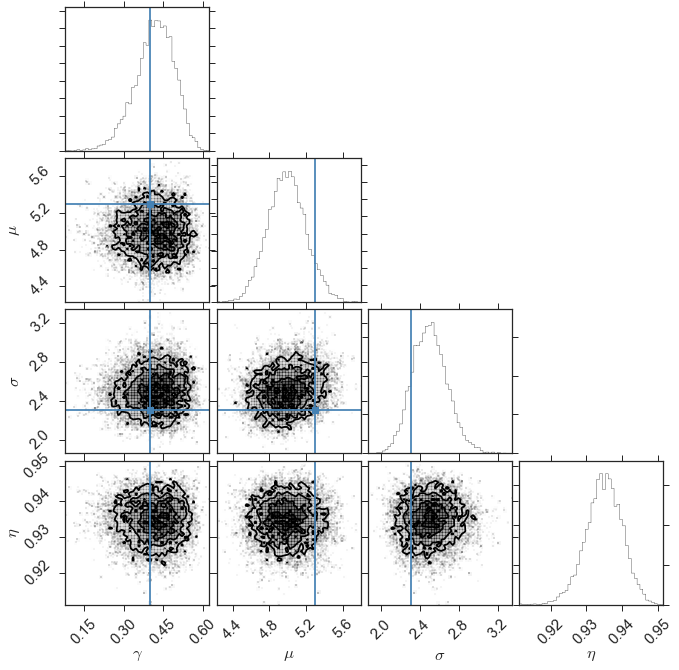

In [7]:
par_ranges = [[0, 0.999], [1e-3, 10], [1e-3, 10], [0, 0.999] ]
malm_fitter.fit(backend='emcee', nwalkers=100, n_burn=150, n_prod=250, guess=False, 
                         initial_pars=par_ranges)
malm_fitter.triangle(truths=[0.4, np.log(200), np.log(10), 0.7])
plt.savefig('Figures/Triangle_malmquist.png')

The malmquist correction works, but is pretty sensitive to the parameters used in the Malmquist correction. Since the malmquist correction parameters come from simulating a sample with some maximum radius, it is kind of scary... In fact, if you use a different maximum radius you end up with the wrong answer! Look at this triangle plot similar to the one above, but with a different set of parameters:

<img src="Figures/Triangle_malmquist_bad_malmcorr.png" >

What do I do for the real sample, and how do I know that I get it right??